In [16]:
from netCDF4 import Dataset
from glob import glob
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'vert-wind-contour-vid.ju.py'
RUN_ID = int(sys.argv[1]) if is_py and len(sys.argv) > 1 else 45

root_dir = '/home/guc/'
data_dir = f'runs/{RUN_ID:03}*/'
root_data_dir = glob(root_dir + data_dir)[0]

image_dir = root_data_dir + 'results/images/'
if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

dataset = Dataset(glob(f'{root_dir}runs/{RUN_ID:03}-*/wrfout*')[0])

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 12

# === EDIT COORDS HERE ===
START = (33, 140) # Y, X
END = (37, 140) # Y, X

start_point = CoordPair(lat = START[0], lon = START[1])
end_point = CoordPair(lat = END[0], lon = END[1])
vert_levels = np.linspace(0, 6500, 200)
z_data = getvar(dataset, "z", timeidx=0)

def get_cross_var(var, time_idx):
    return vertcross(
        var,
        z_data,
        levels=vert_levels,
        wrfin=dataset,
        timeidx=time_idx,
        start_point=start_point,
        end_point=end_point,
        latlon=True,
        meta=True
    )

In [96]:
import math

def generate_frame(time_idx, date_time = np.datetime64('1970-01-01')):
    u_data = getvar(dataset, "ua", timeidx=time_idx)
    v_data = getvar(dataset, "va", timeidx=time_idx)
    w_data = getvar(dataset, "wa", timeidx=time_idx)
    var_data = getvar(dataset, "T", timeidx=time_idx)
    qrain_data = getvar(dataset, "QRAIN", timeidx=time_idx)
    qvapor_data = getvar(dataset, "QVAPOR", timeidx=time_idx)

    pblh_data = to_np(getvar(dataset, "PBLH", timeidx=time_idx))
    pblh_data = np.repeat(pblh_data[None, :, :], 44, axis=0) # Copy the value to make it 3d

    u_cross = get_cross_var(u_data, time_idx)
    v_cross = get_cross_var(v_data, time_idx)
    w_cross = get_cross_var(w_data, time_idx)
    var_cross = get_cross_var(var_data, time_idx) + 300 - 273.15
    qrain_cross = get_cross_var(qrain_data, time_idx)
    qvapor_cross = get_cross_var(qvapor_data, time_idx)
    pblh_cross = get_cross_var(pblh_data, time_idx)

    plt.figure(figsize=(6.5, 4)) # width, height
    ax = plt.axes()

    coord_pairs = to_np(var_cross.coords['xy_loc'])
    coord_pair_labels = [f'{float(pair.latlon_str().split(',')[0]):.1f}' for pair in to_np(coord_pairs)]
    ax.set_xticks(np.arange(coord_pairs.shape[0])[::12])

    mask_x = slice(None, None, 3)
    mask_y = slice(None, None, 10)

    plt.ylabel('Height (m)')
    plt.xlabel('Latitude (Longitude = 140)')

    plot_lim = np.linspace(math.floor(0 + 300 - 273.15), math.ceil(10 + 300 - 273.15), 51) # T
    plt.contourf(coord_pair_labels, vert_levels, var_cross, plot_lim, cmap="nipy_spectral", extend="both")

    qrain_plot_lim = np.linspace(1, 9, 5) # QRAIN * 1e5
    qrain_contour = ax.contourf(
        coord_pair_labels,
        vert_levels,
        qrain_cross * 1e5,
        qrain_plot_lim,
        cmap="Blues",
        alpha=0.5,
        extend="max"
    )

    qvapor_plot_lim = np.linspace(0, 3, 10) # QVAPOR * 1e2
    ax.contour(
        coord_pair_labels,
        vert_levels,
        qvapor_cross * 1e2,
        qvapor_plot_lim,
        colors="#283593",
        linewidths=0.7,
        linestyles="dotted",
    )
    ax.plot( [], [], color="#283593", linewidth=0.7, linestyle="dotted", label="QVAPOR") # Legend "hack"

    ax.plot(coord_pair_labels, pblh_cross[-1], linestyle="dashdot", color="#5D4037", linewidth=1, label="PBLH")

    cbar = plt.colorbar(qrain_contour, shrink=.9, pad=0.1)
    cbar.ax.set_ylabel('Water-Rain Mixing Ratio ($\\times 10^{-5}$)')

    cbar = plt.colorbar(shrink=.9, ticks=plot_lim[::10])
    cbar.ax.set_ylabel('Potential Temperature (C)')


    ax.quiver(
        coord_pair_labels[mask_x],
        to_np(vert_levels)[mask_y],
        to_np(v_cross)[mask_y, mask_x],
        to_np(w_cross * 50)[mask_y, mask_x],
        color="#444",
        scale=100,
        width=0.003
    )

    plt.title(f"Average Wind Velocity (m/s) Vertical Cross\nat {date_time}, AHE=100")
    plt.legend(loc="upper right")
    if is_py:
        plt.savefig(image_dir + np.datetime_as_string(date_time, unit='s') + '.png', bbox_inches='tight')

def generate_video():
    times = extract_times(dataset, timeidx=ALL_TIMES)
    for time_idx, date_time in enumerate(times):
        print(f'Processing {date_time}', end='\r')
        generate_frame(time_idx, date_time)
        plt.close()

Starting visualization for vert-wind-contour for run id 45


/home/guc/miniconda3/lib/python3.12/site-packages/wrf/metadecorators.py:1109: UserWarning: 'latlon' is set to True, but 'field3d' is not of type xarray.DataArray and contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' is "


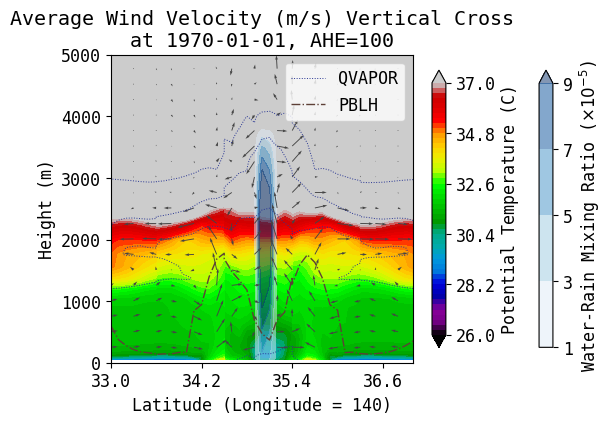

In [100]:
import subprocess

print(f'Starting visualization for vert-wind-contour for run id {RUN_ID}')

if is_py:
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    generate_video()
    subprocess.call(['/home/guc/scripts/visualize/generate-video.sh', f'{RUN_ID:03}'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/{RUN_ID:03}-{len(glob(root_dir + f'results/{RUN_ID:03}*.mp4')) + 1}.mp4'])
    print('Done!!')
else:
    generate_frame(70)
    # plt.savefig('/home/guc/results/test-fig.png', bbox_inches='tight')